In [1]:
import numpy as np
import matplotlib.pyplot as plt

# **[Q2] Diffusion Model Explorations [4+4 pts]**

As extensively discussed in class, the drift-diffusion model (DDM) generates two response time (RT) distributions, one for each boundary (i.e., lower and upper boundaries). This exercise asks you to first explore a somewhat counterintuitive question about the basic DDM: What differences between the means of the two RT distributions does the the model predict?

To approach this question from a simulation-based perspective, you need to repeatedly solve the forward problem with different parameter configurations and collect the two summary statistics, namely, the two empirical means of the resulting RT distributions. First, choose a suitable configuration of the four parameters and vary only the drift rates within a reasonable range (e.g., $v \in [0.5-1.5]$) for a total of $25$ different drift rates. Make sure that your parameterizations can generate a sufficient number of RTs for both distributions and you don’t end up with the process only reaching the upper boundary. Second, for each of your parameter configurations, generate $N = 2000$ synthetic observations and estimate the means of the two distributions. What do you observe regarding the mean difference? Describe and interpret your results. **[4 pts]**

In a similar spirit (keeping all parameters fixed and varying one), explore the effects of each of the parameters on the means and standard deviations of the simulated RT distributions, quantify and describe your results. **[4 pts]**

In [2]:
"""
[reused from `response_times_and_walks.ipynb`]
Simulates one realization of the diffusion process 
given a set of parameters and a step size `dt`.

Parameters:
-----------
v     : float
    The drift rate (rate of information uptake)
a     : float
    The boundary separation (decision threshold).
beta  : float in [0, 1]
    Relative starting point (prior option preferences)
tau   : float
    Non-decision time (additive constant)
dt    : float, optional (default: 1e-3 = 0.001)
    The step size for the Euler algorithm.
scale : float, optional (default: 1.0)
    The scale (sqrt(var)) of the Wiener process. Not considered
    a parameter and typically fixed to either 1.0 or 0.1.
max_time: float, optional (default: .10)
    The maximum number of seconds before forced termination.

Returns:
--------
(x, c) - a tuple of response time (y - float) 
    and a binary decision (c - int) 
"""
def simulate_diffusion(v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10.):
    # Inits (process starts at relative starting point)
    y = beta*a
    num_steps = tau
    const = scale*np.sqrt(dt)

    # Loop through process and check boundary conditions
    while (y <= a and y >= 0) and (num_steps <= max_time):
        # Perform diffusion equation
        z = np.random.randn()
        y += v*dt + const*z

        # Increment step counter
        num_steps += dt
    
    if y >= a:
        c = 1
    else:
        c = 0
    return (round(num_steps, 3), c)

"""
[reused from `response_times_and_walks.ipynb`]
Simulates `num_sims` realizations of the diffusion process 
given a set of parameters and a step size `dt`.

Returns:
data - a np.array of shape (num_sims, 2)
"""
def simulate_diffusion_n(num_sims, v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10.):
    data = np.zeros((num_sims, 2))
    for n in range(num_sims):
        data[n, :] = simulate_diffusion(v, a, beta, tau, dt, scale, max_time)
    return data

In [3]:
"""
param_to_vary : string in ["v", "a", "beta", "tau"]
    Which of the 4 parameters will be varied
"""
def Q2_run_model(param_to_vary):
    # Base constants/params
    NUM_SIMS = 2000 # Constant given by problem def
    NUM_VARIED_VALUES = 25 # Constant given by problem def
    params = {
        'v': 1.0,
        'a': 3.0,
        'beta': 0.5,
        'tau': 0.7
    }

    # Build values range for the param to be varied
    if (param_to_vary == "v"):
        # v in [0.5, 1.5] (problem def)
        varied_range = {'start': 0.5, 'stop': 1.5}
    elif (param_to_vary == "a"):
        # [2.0, ..., 3.0, ..., 4.0]
        varied_range = {'start': 2.0, 'stop': 4.0}
    elif (param_to_vary == "beta"):
        # beta by definition is ranged in [0.0, 1.0]
        varied_range = {'start': 0.0, 'stop': 1.0}
    elif (param_to_vary == "tau"):
        # [0.0, ..., 0.7, ..., 1.4]
        varied_range = {'start': 0.0, 'stop': 1.4}
    else:
        raise Exception("invalid input for `param_to_vary`")
    
    param_varied_arr = np.linspace(**varied_range, num=NUM_VARIED_VALUES)

    data = np.zeros((len(param_varied_arr), NUM_SIMS, 2))
    for idx in range(len(param_varied_arr)):
        params[param_to_vary] = param_varied_arr[idx]
        data[idx, :, :] = simulate_diffusion_n(NUM_SIMS, **params)

    return data, param_varied_arr

In [4]:
"""
Calc mean of the RTs (response times) for the lower and upper boundaries (for each of the 25 varied param values), 
then do the same for the std devs of the RTs
"""
def Q2_calc_mean_and_stddev(data):
    lower_bound_RTs_means = np.mean(data[:,:,0], where=(data[:,:,1]==0), axis=1)
    upper_bound_RTs_means = np.mean(data[:,:,0], where=(data[:,:,1]==1), axis=1)
    
    lower_bound_RTs_stddevs = np.std(data[:,:,0], where=(data[:,:,1]==0), axis=1)
    upper_bound_RTs_stddevs = np.std(data[:,:,0], where=(data[:,:,1]==1), axis=1)

    return lower_bound_RTs_means, upper_bound_RTs_means, lower_bound_RTs_stddevs, upper_bound_RTs_stddevs

In [5]:
"""
[]
"""
def Q2_plot_results(param_to_vary, param_varied_arr, 
                    lower_bound_RTs_means, upper_bound_RTs_means, 
                    lower_bound_RTs_stddevs, upper_bound_RTs_stddevs):

    # ax[0] plots the diff between means, ax[1] plots the means, ax[2] plots the stddevs
    f, ax = plt.subplots(1, 3, figsize=(14, 4))

    xlabel_str = ""
    if (param_to_vary == "v"):
        xlabel_str = "Drift rate (v)"
    elif (param_to_vary == "a"):
        xlabel_str = "Boundary separation (a)"
    elif (param_to_vary == "beta"):
        xlabel_str = "Starting point (\u03B2)"
    elif (param_to_vary == "tau"):
        xlabel_str = "Non-decision time (\u03C4)"

    # plot difference between the RT means
    ax[0].set_xlabel(xlabel_str)
    ax[0].set_ylabel("RT mean difference")
    ax[0].plot(param_varied_arr, np.abs(upper_bound_RTs_means-lower_bound_RTs_means), 
               c="g", label="Abs Difference")
    ax[0].legend()
    
    # plot RT means
    ax[1].set_xlabel(xlabel_str)
    ax[1].set_ylabel("RT mean")
    #ax[1].set_xlim(param_varied_arr[0]-0.02, param_varied_arr[-1]+0.02)
    ax[1].plot(param_varied_arr, upper_bound_RTs_means, 
               c="b", label="Upper Boundary")
    ax[1].plot(param_varied_arr, lower_bound_RTs_means, 
               c="r", label="Lower Boundary")
    ax[1].legend()

    # plot RT std devs
    ax[2].set_xlabel(xlabel_str)
    ax[2].set_ylabel("RT standard deviation")
    ax[2].plot(param_varied_arr, upper_bound_RTs_stddevs, 
               c="b", label="Upper Boundary")
    ax[2].plot(param_varied_arr, lower_bound_RTs_stddevs, 
               c="r", label="Lower Boundary")
    ax[2].legend()

In [6]:
def Q2_main(param_to_vary, data, param_varied_arr):
    #data, param_varied_arr = Q2_run_model(param_to_vary) # better to do this outside
    
    lower_bound_RTs_means, upper_bound_RTs_means, lower_bound_RTs_stddevs, upper_bound_RTs_stddevs = Q2_calc_mean_and_stddev(data)

    Q2_plot_results(param_to_vary, param_varied_arr, 
                    lower_bound_RTs_means, upper_bound_RTs_means, 
                    lower_bound_RTs_stddevs, upper_bound_RTs_stddevs)

## **Results**

In [7]:
# Run all models
data_v, param_varied_arr_v = Q2_run_model("v")
data_a, param_varied_arr_a = Q2_run_model("a")
data_beta, param_varied_arr_beta = Q2_run_model("beta")
data_tau, param_varied_arr_tau = Q2_run_model("tau")

### **Drift rate ($v$)** 

**What do you observe regarding the mean difference? Describe and interpret your results.**

It's hard to really make any significant observations regarding the mean difference. It seems to bound around more or less at random. This is presumably due to the responses hitting the upper boundary more often (across the whole range), so the lower boundary might have more variance.

**Describe the effects of varying the parameter on the means and standard deviations of the simulated RT distributions.**

As the drift rate $v$ increased, the RT means and std devs for both boundaries decrease (though both lower boundary lines are somewhat erratic).

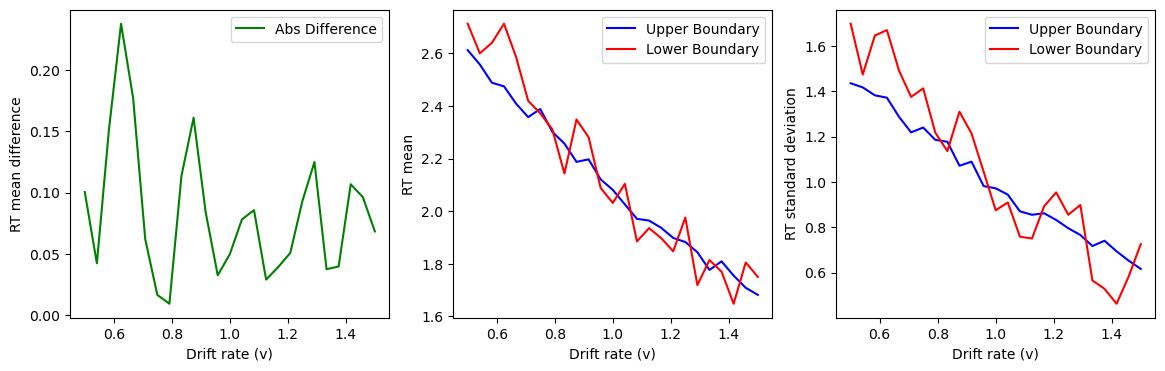

In [8]:
# Drift rate (v)
#data_v, param_varied_arr_v = Q2_run_model("v")
Q2_main("v", data_v, param_varied_arr_v)

### **Boundary separation ($a$)** 

**Describe the effects of varying the parameter on the means and standard deviations of the simulated RT distributions.**

Over the whole range, as the boundary separation $a$ increased the RT means and std devs also increased (though not too much for the std devs). 

From $a = 2.0$ to $a \approx 3.0$, the RT means for the boundaries are very close. However, from $a \approx 3.3$ to $a = 4.0$, the lower boundary's mean and std dev becomes much more variable, with the std dev also jumping up.

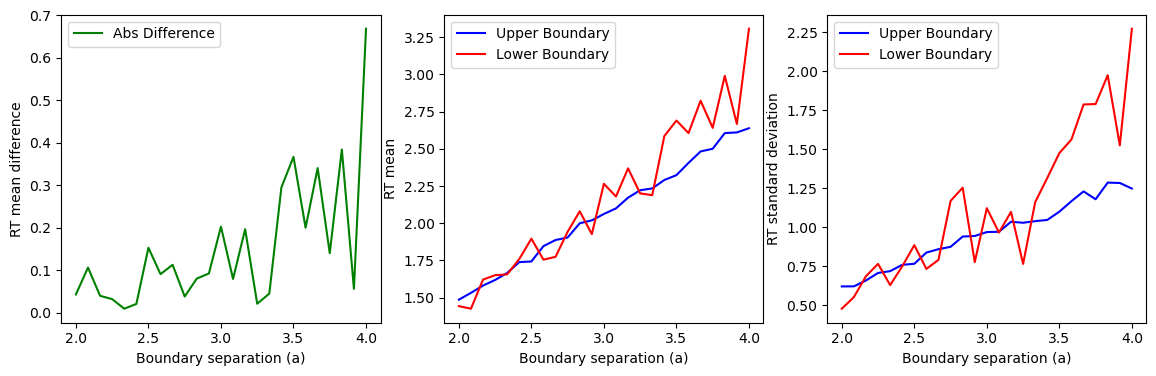

In [9]:
# Boundary separation (a)
#data_a, param_varied_arr_a = Q2_run_model("a")
Q2_main("a", data_a, param_varied_arr_a)

### **Starting point ($\beta$)** 

**Describe the effects of varying the parameter on the means and standard deviations of the simulated RT distributions.**

As the starting point $\beta$ increased from 0 to 1, the upper boundary's mean RT and std dev decreased, while the lower boundary's mean RT increased. The lower boundary's std dev increased, peaked around $\beta = 0.5$, then decreased. The mean RT lines intersected right around $\beta = 0.5$.

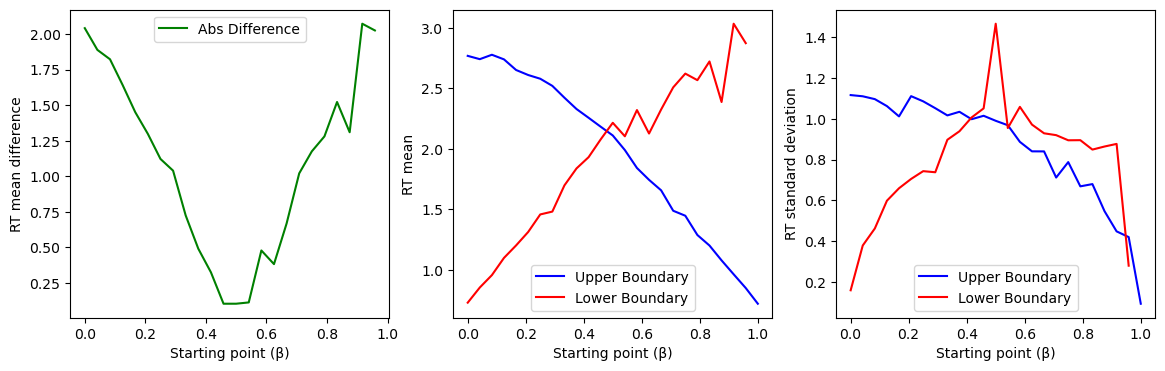

In [14]:
# Starting point (beta)
#data_beta, param_varied_arr_beta = Q2_run_model("beta")
Q2_main("beta", data_beta, param_varied_arr_beta)

#### **Non-decision time ($\tau$)** 

**Describe the effects of varying the parameter on the means and standard deviations of the simulated RT distributions.**

As the non-decision time $\tau$ increased, the mean RT for both boundaries also increased linearly. Since $\tau$ is just a constant added to each value, it makes sense that it would just increase the means of both. The RT standard devations also weren't affected in a significant way, since the variation is fairly uniform across the range of $\tau$ and thus is probably just due to inherient randomness in the simulation.

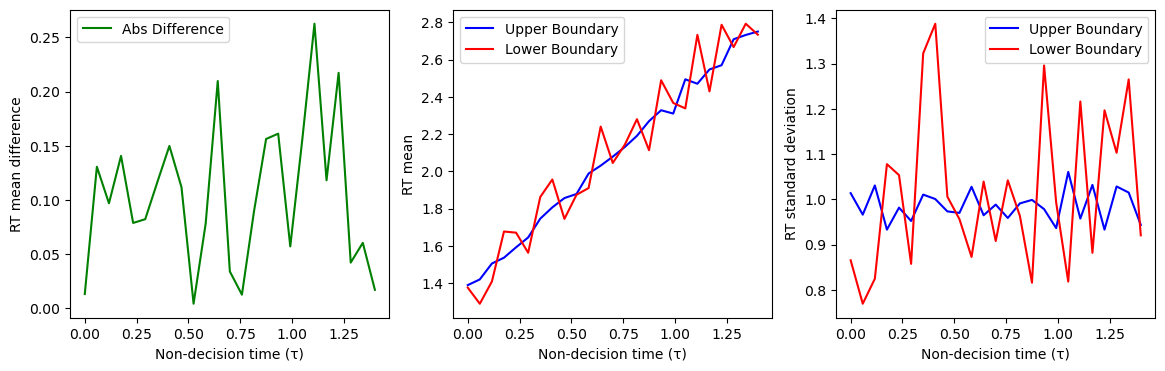

In [11]:
# Non-decision time (tau)
#data_tau, param_varied_arr_tau = Q2_run_model("tau")
Q2_main("tau", data_tau, param_varied_arr_tau)